In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

warnings.filterwarnings('ignore')
print("Libraries Imported Successfully.")

Libraries Imported Successfully.


In [2]:
try:
    print("Loading Dataset 1 (Yield)...")
    df_yield = pd.read_csv('Datasets/DF_1_FAOSTAT_data_en_11-19-2025.csv')
    
    print(f"Shape: {df_yield.shape}")
    print("Head:")
    display(df_yield.head())
except Exception as e:
    print(f"Error: {e}")

Loading Dataset 1 (Yield)...
Shape: (5940, 15)
Head:


,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,QCL,Crops and livestock products,356,India,5312,Area harvested,1654.0,"Anise, badian, coriander, cumin, caraway, fenn...",2000,2000,ha,344434.0,A,Official figure,NaN
1,QCL,Crops and livestock products,356,India,5412,Yield,1654.0,"Anise, badian, coriander, cumin, caraway, fenn...",2000,2000,kg/ha,484.0,A,Official figure,NaN
2,QCL,Crops and livestock products,356,India,5510,Production,1654.0,"Anise, badian, coriander, cumin, caraway, fenn...",2000,2000,t,166692.0,A,Official figure,NaN
3,QCL,Crops and livestock products,356,India,5312,Area harvested,1654.0,"Anise, badian, coriander, cumin, caraway, fenn...",2001,2001,ha,569271.0,A,Official figure,NaN
4,QCL,Crops and livestock products,356,India,5412,Yield,1654.0,"Anise, badian, coriander, cumin, caraway, fenn...",2001,2001,kg/ha,430.3,A,Official figure,NaN


In [3]:
try:
    print("Loading Dataset 2 (Soil)...")
    df_soil = pd.read_csv('Datasets/DF_2_Crop_recommendation.csv')
    
    print(f"Shape: {df_soil.shape}")
    print("Head:")
    display(df_soil.head())
except Exception as e:
    print(f"Error: {e}")

Loading Dataset 2 (Soil)...
Shape: (2200, 8)
Head:


,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [4]:
try:
    print("Filtering for India Dataset 1 (Yield) ...")
    

    df_yield_clean = df_yield[
        (df_yield['Area'] == 'India') #& 
        #(df_yield['Element'] == 'Production')
    ].copy()

 
    
    print(f"Filtered Shape: {df_yield_clean.shape}")
    display(df_yield_clean.head())

except Exception as e:
    print(f"Error: {e}")


Filtering for India Dataset 1 (Yield) ...
Filtered Shape: (5940, 15)


,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,QCL,Crops and livestock products,356,India,5312,Area harvested,1654.0,"Anise, badian, coriander, cumin, caraway, fenn...",2000,2000,ha,344434.0,A,Official figure,NaN
1,QCL,Crops and livestock products,356,India,5412,Yield,1654.0,"Anise, badian, coriander, cumin, caraway, fenn...",2000,2000,kg/ha,484.0,A,Official figure,NaN
2,QCL,Crops and livestock products,356,India,5510,Production,1654.0,"Anise, badian, coriander, cumin, caraway, fenn...",2000,2000,t,166692.0,A,Official figure,NaN
3,QCL,Crops and livestock products,356,India,5312,Area harvested,1654.0,"Anise, badian, coriander, cumin, caraway, fenn...",2001,2001,ha,569271.0,A,Official figure,NaN
4,QCL,Crops and livestock products,356,India,5412,Yield,1654.0,"Anise, badian, coriander, cumin, caraway, fenn...",2001,2001,kg/ha,430.3,A,Official figure,NaN


In [5]:
try:
    print("--- Data BEFORE Explosion ---")
    mixed_crop_example = df_yield[df_yield['Item'].str.contains(',')].head(1)
    
    if not mixed_crop_example.empty:
        print("Example of a cell with multiple/mixed data:")
        display(mixed_crop_example)
    else:
        print("No mixed cells found in head, showing general head:")
        display(df_yield_clean.head())
        
    print(f"Total Rows Before: {df_yield.shape[0]}")
except Exception as e:
    print(f"Error: {e}")

--- Data BEFORE Explosion ---
Example of a cell with multiple/mixed data:


,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note
0,QCL,Crops and livestock products,356,India,5312,Area harvested,1654.0,"Anise, badian, coriander, cumin, caraway, fenn...",2000,2000,ha,344434.0,A,Official figure,NaN


Total Rows Before: 5940


In [6]:
try:
    print("--- Explosion & Robust Cleaning ---")
    
    # 1. EXPLODE (Split Mixed Rows)
    df_yield_clean['Item_List'] = df_yield_clean['Item'].str.replace(' and ', ',')
    df_yield_clean['Item_List'] = df_yield_clean['Item_List'].str.split(',')
    df_exploded = df_yield_clean.explode('Item_List')
    
    # 2. BASE CLEANING
    # Create a 'Join_Key' for matching, but KEEP 'Item' for display
    df_exploded['Join_Key'] = df_exploded['Item_List'].str.strip().str.lower()
    df_soil['Join_Key'] = df_soil['label'].str.strip().str.lower()

    print(f"Rows Before Explosion: {df_yield_clean.shape[0]}")
    print(f"Rows After Explosion:  {df_exploded.shape[0]}")
    
except Exception as e:
    print(f"Error: {e}")

--- Explosion & Robust Cleaning ---
Rows Before Explosion: 5940
Rows After Explosion:  10519


In [7]:
try:
    print("--- Data AFTER Explosion ---")
    
    print(f"Total Rows After: {df_exploded.shape[0]}")
    print("(Rows increased because split items are now on separate lines)")
    
    print("Sample of Exploded Data:")
    display(df_exploded.head())
except Exception as e:
    print(f"Error: {e}")

--- Data AFTER Explosion ---
Total Rows After: 10519
(Rows increased because split items are now on separate lines)
Sample of Exploded Data:


,Domain Code,Domain,Area Code (M49),Area,Element Code,Element,Item Code (CPC),Item,Year Code,Year,Unit,Value,Flag,Flag Description,Note,Item_List,Join_Key
0,QCL,Crops and livestock products,356,India,5312,Area harvested,1654.0,"Anise, badian, coriander, cumin, caraway, fenn...",2000,2000,ha,344434.0,A,Official figure,NaN,Anise,anise
0,QCL,Crops and livestock products,356,India,5312,Area harvested,1654.0,"Anise, badian, coriander, cumin, caraway, fenn...",2000,2000,ha,344434.0,A,Official figure,NaN,badian,badian
0,QCL,Crops and livestock products,356,India,5312,Area harvested,1654.0,"Anise, badian, coriander, cumin, caraway, fenn...",2000,2000,ha,344434.0,A,Official figure,NaN,coriander,coriander
0,QCL,Crops and livestock products,356,India,5312,Area harvested,1654.0,"Anise, badian, coriander, cumin, caraway, fenn...",2000,2000,ha,344434.0,A,Official figure,NaN,cumin,cumin
0,QCL,Crops and livestock products,356,India,5312,Area harvested,1654.0,"Anise, badian, coriander, cumin, caraway, fenn...",2000,2000,ha,344434.0,A,Official figure,NaN,caraway,caraway


In [8]:
try:
    print("Preparing Keys for Merging (Final 18-Crop Fix)...")
    
    # 1. Clean Keys using the EXPLODED column
    df_exploded['Join_Key'] = df_exploded['Item_List'].str.strip().str.lower()
    df_soil['Join_Key'] = df_soil['label'].str.strip().str.lower()

    # 2. MASTER DICTIONARY
    name_fixer = {
        # --- FRUITS ---
        'apples': 'apple',
        'bananas': 'banana',
        'mangoes': 'mango',
        'grapes': 'grapes',
        'watermelons': 'watermelon',
        'papayas': 'papaya',
        'oranges': 'orange',
        'pomegranates': 'pomegranate',
        'coconuts': 'coconut',
        'coconuts, in shell': 'coconut',
        
        # --- MELONS (THE FIX) ---
        # The split logic turned "Cantaloupes and other melons" into "Cantaloupes"
        'cantaloupes': 'muskmelon', 
        'cantaloupes and other melons': 'muskmelon',
        
        # --- GRAINS & COMMERCIAL ---
        'rice': 'rice',
        #'paddy': 'rice',
        #'maize': 'maize',
        'maize (corn)': 'maize',
        'jute': 'jute',
        #'jute, raw or retted': 'jute',
        'coffee': 'coffee',
        #'coffee, green': 'coffee',
        #'cotton': 'cotton',
        'seed cotton': 'cotton',
        'seed cotton, unginned': 'cotton',
        
        # --- PULSES (THE FIX for Missing Crops) ---
        'chick peas': 'chickpea',
        'chick peas, dry': 'chickpea',
        'pigeon peas': 'pigeonpeas',
        'pigeon peas, dry': 'pigeonpeas',
        'lentils': 'lentil',
        'lentils, dry': 'lentil',

       

        #'black gram': 'blackgram',
        
        # MAPPING GENERIC CATEGORIES TO SPECIFIC MISSING CROPS
        #'other pulses n.e.c.': 'mothbeans',   # Catch Mothbeans here
        'beans': 'mothbeans',
        #'other beans, green': 'mungbean',     # Catch Mungbeans here
     
        'moth beans': 'mothbeans'
    }
    
    # Apply Map
    df_exploded['Join_Key'] = df_exploded['Join_Key'].replace(name_fixer)
    df_exploded = df_exploded[df_exploded['Join_Key'] != '']

    # VERIFICATION
    soil_crops = set(df_soil['Join_Key'].unique())
    yield_crops = set(df_exploded['Join_Key'].unique())
    common = yield_crops.intersection(soil_crops)
    
    print(f"✅ Matching Keys Found: {len(common)}")
    print(f"List: {sorted(list(common))}")

except Exception as e:
    print(f"Error: {e}")

Preparing Keys for Merging (Final 18-Crop Fix)...
✅ Matching Keys Found: 18
List: ['apple', 'banana', 'chickpea', 'coconut', 'coffee', 'cotton', 'grapes', 'jute', 'lentil', 'maize', 'mango', 'mothbeans', 'muskmelon', 'orange', 'papaya', 'pigeonpeas', 'rice', 'watermelon']


In [9]:
try:
    print("Merging Datasets (Inner Join)...")
    
    # 1. INNER JOIN
    final_df = pd.merge(
        df_exploded,
        df_soil,
        on='Join_Key',
        how='inner' 
    )
    
    # 2. FILL NULLS
    soil_cols = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
    for col in soil_cols:
        final_df[col] = final_df[col].fillna(final_df[col].mean())

    # 3. RENAME & DROP
    if 'label' in final_df.columns:
        final_df.drop(columns=['label'], inplace=True)

    final_df.rename(columns={'Item': 'label'}, inplace=True)

    # 4. BEAUTIFY LABELS (Clean up the names for the graph)
    label_cleaner = {
        'Coffee, green': 'Coffee',
        'Coconuts, in shell': 'Coconut',
        'Maize (corn)': 'Maize',
        'Jute, raw or retted': 'Jute',
        'Seed cotton, unginned': 'Cotton',
        'Chick peas, dry': 'Chickpea',
        'Pigeon peas, dry': 'Pigeonpeas',
        'Lentils, dry': 'Lentil',
        'Mangoes, guavas and mangosteens': 'Mango',
        'cantaloupes': 'Muskmelon', 
        'Cantaloupes and other melons': 'Muskmelon',
        'Beans, dry': 'Beans',
        
        'Other pulses n.e.c.': 'Mothbeans', # Display correctly
      
        'Apples': 'Apple',
        'Bananas': 'Banana',
        'Grapes': 'Grapes',
        'Oranges': 'Orange',
        'Papayas': 'Papaya',
        'Rice': 'Rice',
        'Paddy': 'Rice',
        'Watermelons': 'Watermelon'
    }
    
    final_df['label'] = final_df['label'].replace(label_cleaner)

    # 5. STRICT SELECTION
    target_cols = ['Element', 'Value', 'N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'label']
    final_df = final_df[target_cols]
    
    print(f"Merge Success!")
    print(f"Final Data Shape: {final_df.shape}")
    
    # PROOF
    print(f"\nUnique Crops: {final_df['label'].nunique()}")
    print("Crops List:", sorted(final_df['label'].unique()))
    
    display(final_df.head())

except Exception as e:
    print(f"Error: {e}")

Merging Datasets (Inner Join)...
Merge Success!
Final Data Shape: (129600, 10)

Unique Crops: 18
Crops List: ['Apple', 'Banana', 'Beans', 'Chickpea', 'Coconut', 'Coffee', 'Cotton', 'Grapes', 'Jute', 'Lentil', 'Maize', 'Mango', 'Muskmelon', 'Orange', 'Papaya', 'Pigeonpeas', 'Rice', 'Watermelon']


,Element,Value,N,P,K,temperature,humidity,ph,rainfall,label
0,Area harvested,230000.0,24,128,196,22.750888,90.694892,5.521467,110.431786,Apple
1,Area harvested,230000.0,7,144,197,23.849401,94.348150,6.133221,114.051249,Apple
2,Area harvested,230000.0,14,128,205,22.608010,94.589006,6.226290,116.039659,Apple
3,Area harvested,230000.0,8,120,201,21.186674,91.134357,6.321152,122.233323,Apple
4,Area harvested,230000.0,20,129,201,23.410447,91.699133,5.587906,116.077793,Apple


In [10]:
try:
    print("--- Filtering & Cleaning ---")
    
    # 1. Check Elements before filtering
    print("Elements present before filtering:")
    print(final_df['Element'].unique())

    # 2. Filter: Keep only 'Production' rows
    final_df = final_df[final_df['Element'] == 'Production'].copy()
    
    # 3. Verify Filtering
    print("Elements present after filtering:")
    print(final_df['Element'].unique())
    
    # --- DISPLAY BEFORE DROPPING ---
    print("\nData Head BEFORE dropping 'Element':")
    display(final_df.head())
    
    # 4. Drop 'Element' Column
    final_df.drop(columns=['Element'], inplace=True)
    print("\nDropped 'Element' column.")
    
    # --- DISPLAY AFTER DROPPING ---
    print("Data Head AFTER dropping 'Element':")
    display(final_df.head())


    print("Crops Included:", final_df['label'].unique())

    print("Total No. of Crops Included:", len(final_df['label'].unique()))
    
    # 5. Final Shape Check
    print(f"\nFiltered Data Shape (Production Only): {final_df.shape}")

except Exception as e:
    print(f"Error: {e}")

--- Filtering & Cleaning ---
Elements present before filtering:
['Area harvested' 'Yield' 'Production']
Elements present after filtering:
['Production']

Data Head BEFORE dropping 'Element':


,Element,Value,N,P,K,temperature,humidity,ph,rainfall,label
200,Production,1050000.0,24,128,196,22.750888,90.694892,5.521467,110.431786,Apple
201,Production,1050000.0,7,144,197,23.849401,94.348150,6.133221,114.051249,Apple
202,Production,1050000.0,14,128,205,22.608010,94.589006,6.226290,116.039659,Apple
203,Production,1050000.0,8,120,201,21.186674,91.134357,6.321152,122.233323,Apple
204,Production,1050000.0,20,129,201,23.410447,91.699133,5.587906,116.077793,Apple



Dropped 'Element' column.
Data Head AFTER dropping 'Element':


,Value,N,P,K,temperature,humidity,ph,rainfall,label
200,1050000.0,24,128,196,22.750888,90.694892,5.521467,110.431786,Apple
201,1050000.0,7,144,197,23.849401,94.348150,6.133221,114.051249,Apple
202,1050000.0,14,128,205,22.608010,94.589006,6.226290,116.039659,Apple
203,1050000.0,8,120,201,21.186674,91.134357,6.321152,122.233323,Apple
204,1050000.0,20,129,201,23.410447,91.699133,5.587906,116.077793,Apple


Crops Included: ['Apple' 'Banana' 'Beans' 'Muskmelon' 'Chickpea' 'Coconut' 'Coffee'
 'Grapes' 'Jute' 'Lentil' 'Maize' 'Mango' 'Orange' 'Papaya' 'Pigeonpeas'
 'Rice' 'Cotton' 'Watermelon']
Total No. of Crops Included: 18

Filtered Data Shape (Production Only): (43200, 9)


In [11]:
try:
    print("--- Dataset Cleaning ---")
    
    print(f"\nFiltered Data Shape (Production Only): {final_df.shape}")
    
    print("\nNull Values BEFORE Filling:")
    print(final_df.isnull().sum())

    if 'Value' in final_df.columns:
        initial_count = final_df.shape[0]
        final_df['Value'] = pd.to_numeric(final_df['Value'], errors='coerce')
        final_df = final_df.dropna(subset=['Value'])
        dropped_count = initial_count - final_df.shape[0]
        print(f"Dropped {dropped_count} rows where 'Value' (Production) was missing.")

    soil_cols = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
    print("Filling missing soil data...")
    
    for col in soil_cols:
        final_df[col] = pd.to_numeric(final_df[col], errors='coerce')
        mean_val = final_df[col].mean()
        if pd.isna(mean_val): mean_val = 0
        final_df[col] = final_df[col].fillna(mean_val)
        
    print("Filling Complete.")
    
    print("\nNull Values AFTER Handling:")
    print(final_df.isnull().sum())
    
    if final_df.isnull().sum().sum() == 0:
        print("Dataset is clean.")
    else:
        print("Warning: Some nulls remain.")

except Exception as e:
    print(f"Error: {e}")

--- Dataset Cleaning ---

Filtered Data Shape (Production Only): (43200, 9)

Null Values BEFORE Filling:
Value          0
N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64
Dropped 0 rows where 'Value' (Production) was missing.
Filling missing soil data...
Filling Complete.

Null Values AFTER Handling:
Value          0
N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64
Dataset is clean.


In [12]:
try:
    print("Checking Duplicates...")
    dupes = final_df.duplicated().sum()
    print(f"Duplicates found: {dupes}")
    
    if dupes > 0:
        final_df = final_df.drop_duplicates()
        print("Duplicates Dropped.")
    print("Checking Duplicates Again After Removing...")
    dupes = final_df.duplicated().sum()
    print(f"Duplicates found: {dupes}")
    display(final_df.tail())
    
    # display(final_df.tail())
    print(f"Final Shape: {final_df.shape}")
except Exception as e:
    print(f"Error: {e}")

Checking Duplicates...
Duplicates found: 600
Duplicates Dropped.
Checking Duplicates Again After Removing...
Duplicates found: 0


,Value,N,P,K,temperature,humidity,ph,rainfall,label
129595,3626000.0,97,12,47,25.287846,89.636679,6.765095,58.286977,Watermelon
129596,3626000.0,110,7,45,26.638386,84.695469,6.189214,48.324286,Watermelon
129597,3626000.0,96,18,50,25.331045,84.305338,6.904242,41.532187,Watermelon
129598,3626000.0,83,23,55,26.897502,83.892415,6.463271,43.971937,Watermelon
129599,3626000.0,120,24,47,26.986037,89.413849,6.260839,58.548767,Watermelon


Final Shape: (42600, 9)


--- Outlier Analysis ---
Visualizing Data Distribution BEFORE Removal...


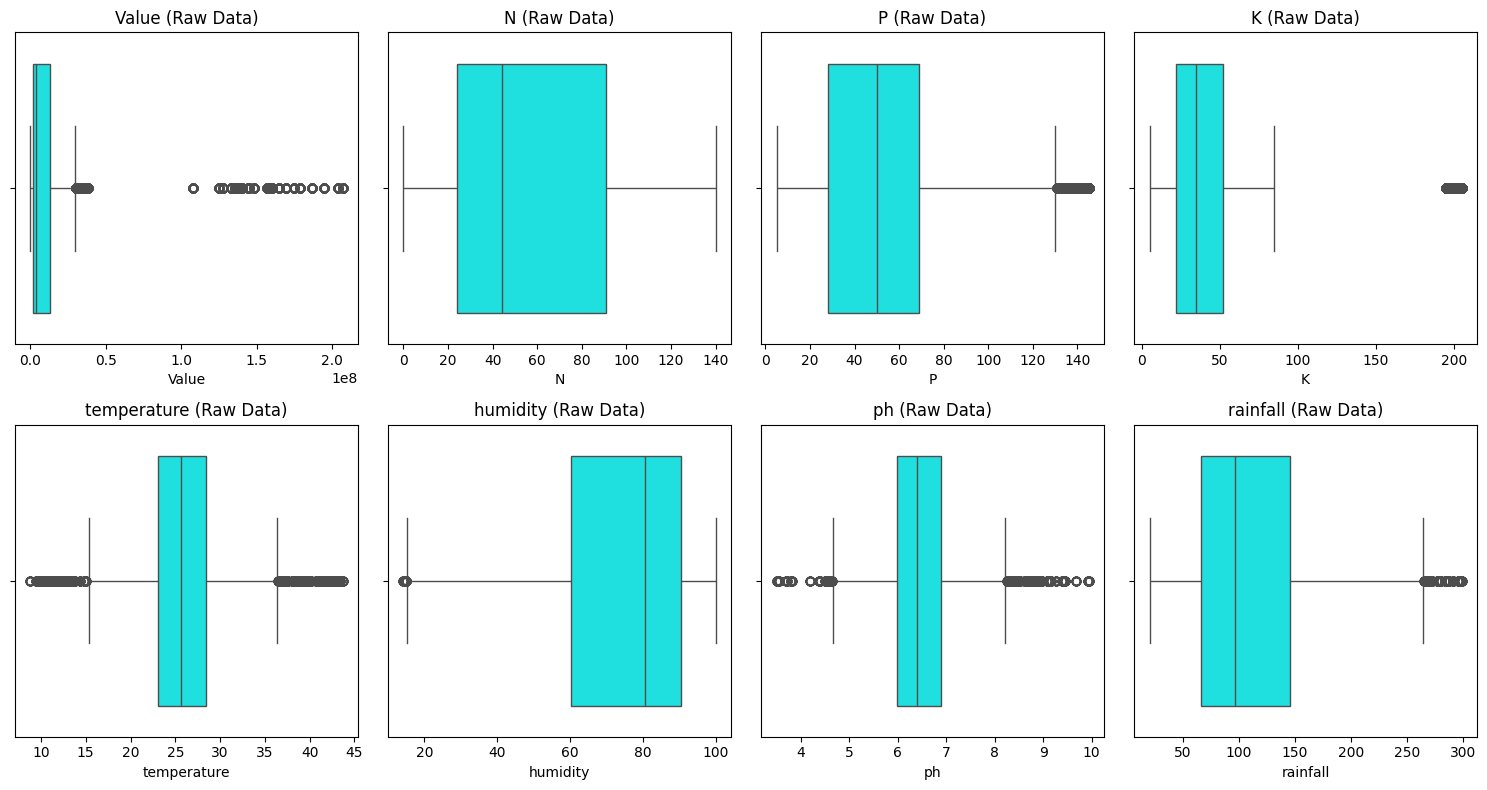

In [13]:
try:
    print("--- Outlier Analysis ---")
    print("Visualizing Data Distribution BEFORE Removal...")

    # Define columns to check
    numeric_cols = ['Value', 'N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
    
    # Ensure numeric
    for col in numeric_cols:
        final_df[col] = pd.to_numeric(final_df[col], errors='coerce')
    
    # Drop rows with missing values in these columns
    final_df = final_df.dropna(subset=numeric_cols)

    # Plot
    plt.figure(figsize=(15, 8))
    for i, col in enumerate(numeric_cols):
        plt.subplot(2, 4, i + 1)
        sns.boxplot(x=final_df[col], color='aqua')
        plt.title(f'{col} (Raw Data)')
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error: {e}")


In [14]:
try:
    print("Crops Included:", final_df['label'].unique())
    print()
    print("Total No. of Crops Included:", len(final_df['label'].unique()))

except Exception as e:
    print(f"Error: {e}")

Crops Included: ['Apple' 'Banana' 'Beans' 'Muskmelon' 'Chickpea' 'Coconut' 'Coffee'
 'Grapes' 'Jute' 'Lentil' 'Maize' 'Mango' 'Orange' 'Papaya' 'Pigeonpeas'
 'Rice' 'Cotton' 'Watermelon']

Total No. of Crops Included: 18


In [15]:
try:
    print("Performing Global Outlier Removal (Standard 1.5 IQR)...")
    
    # 1. Define Numeric Columns
    numeric_cols = ["N", "P", "K", "temperature", "humidity", "ph", "rainfall", "Value"]
    
    # Ensure numeric types
    for col in numeric_cols:
        final_df[col] = pd.to_numeric(final_df[col], errors='coerce')
    
    # 2. Calculate Global Quantiles
    Q1 = final_df[numeric_cols].quantile(0.25)
    Q3 = final_df[numeric_cols].quantile(0.75)
    IQR = Q3 - Q1
    
    # 3. Apply Filter (Remove rows where ANY numeric column is an outlier)
    initial_shape = final_df.shape
    final_df = final_df[~((final_df[numeric_cols] < (Q1 - 1.5 * IQR)) | 
                          (final_df[numeric_cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
    
    # 4. Final Stats
    print(f"Before: {initial_shape}")
    print(f"After: {final_df.shape}")
    print(f"Removed Rows: {initial_shape[0] - final_df.shape[0]}")
    
    # Verify Crop Count
    print(f"Crops Remaining: {final_df['label'].nunique()}")
    print(f"List: {sorted(final_df['label'].unique())}")
        
    # Save
    final_df.to_csv('Datasets/Final_Agri_Data.csv', index=False)

except Exception as e:
    print(f"Error: {e}")

Performing Global Outlier Removal (Standard 1.5 IQR)...
Before: (42600, 9)
After: (30881, 9)
Removed Rows: 11719
Crops Remaining: 15
List: ['Banana', 'Beans', 'Chickpea', 'Coconut', 'Coffee', 'Cotton', 'Jute', 'Lentil', 'Maize', 'Mango', 'Muskmelon', 'Orange', 'Papaya', 'Pigeonpeas', 'Watermelon']


Visualizing Data Distribution AFTER Removal...


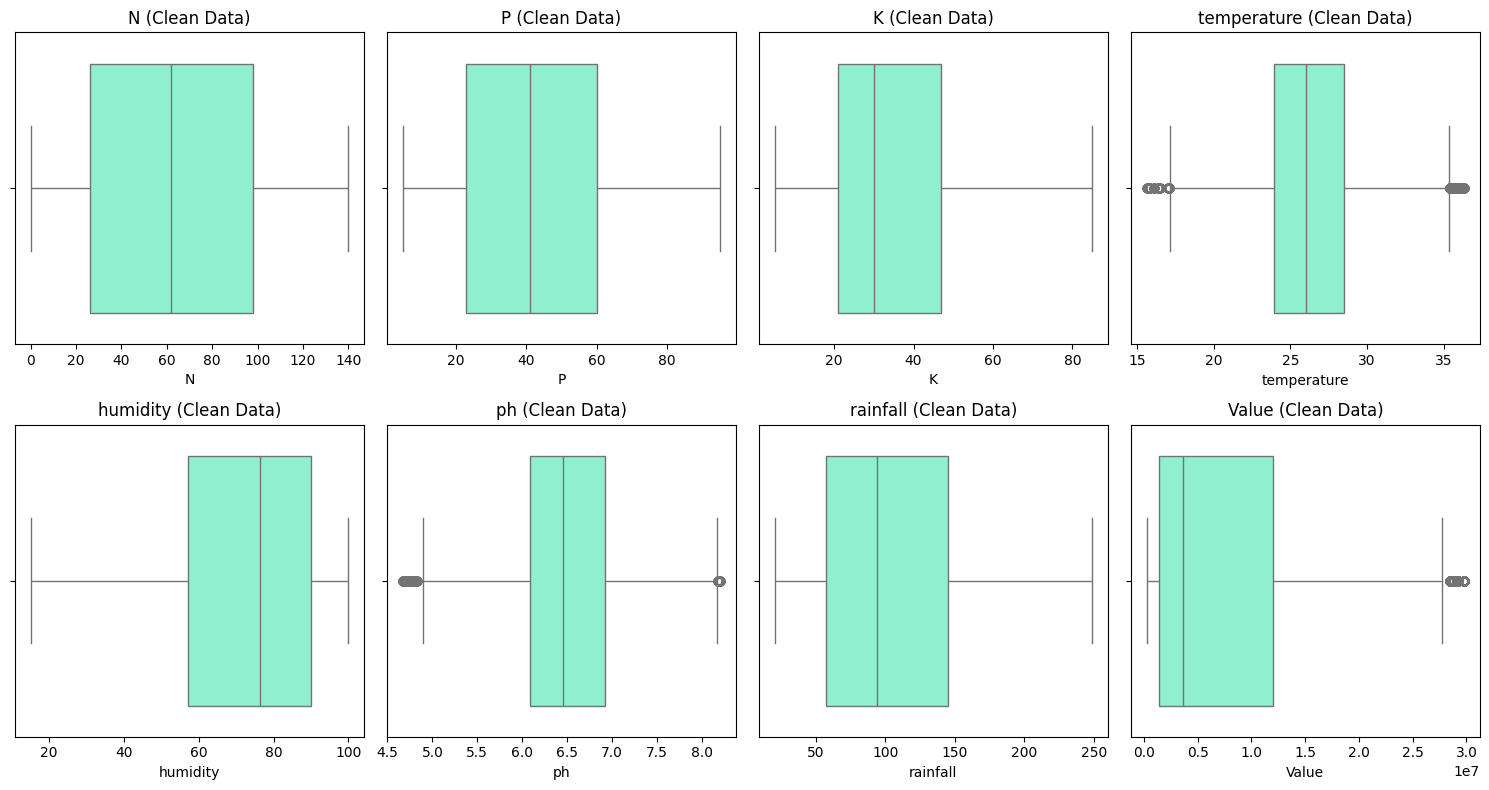

In [16]:
try:
    print("Visualizing Data Distribution AFTER Removal...")

    # Plot Clean Data
    plt.figure(figsize=(15, 8))
    for i, col in enumerate(numeric_cols):
        plt.subplot(2, 4, i + 1)
        sns.boxplot(x=final_df[col], color='aquamarine')
        plt.title(f'{col} (Clean Data)')
    plt.tight_layout()
    plt.show()
    
except Exception as e:
    print(f"Error: {e}")


In [17]:
try:
    print("--- Dataset Cleaning After Removing Outliers ---")
    
    print(f"\nFiltered Data Shape (Production Only): {final_df.shape}")
    
    print("\nNull Values BEFORE Filling:")
    print(final_df.isnull().sum())

    if 'Value' in final_df.columns:
        initial_count = final_df.shape[0]
        final_df['Value'] = pd.to_numeric(final_df['Value'], errors='coerce')
        final_df = final_df.dropna(subset=['Value'])
        dropped_count = initial_count - final_df.shape[0]
        print(f"Dropped {dropped_count} rows where 'Value' (Production) was missing.")

    soil_cols = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
    print("Filling missing soil data...")
    
    for col in soil_cols:
        final_df[col] = pd.to_numeric(final_df[col], errors='coerce')
        mean_val = final_df[col].mean()
        if pd.isna(mean_val): mean_val = 0
        final_df[col] = final_df[col].fillna(mean_val)
        
    print("Filling Complete.")
    
    print("\nNull Values AFTER Handling:")
    print(final_df.isnull().sum())
    
    if final_df.isnull().sum().sum() == 0:
        print("Dataset is clean.")
    else:
        print("Warning: Some nulls remain.")

except Exception as e:
    print(f"Error: {e}")


--- Dataset Cleaning After Removing Outliers ---

Filtered Data Shape (Production Only): (30881, 9)

Null Values BEFORE Filling:
Value          0
N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64
Dropped 0 rows where 'Value' (Production) was missing.
Filling missing soil data...
Filling Complete.

Null Values AFTER Handling:
Value          0
N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64
Dataset is clean.


In [18]:

try:
    # --- FINAL STATS ---
    print(f"\nFinal Dataset Shape: {final_df.shape}")
    print(f"Total Unique Crops: {final_df['label'].nunique()}")
    
    print("\n--- No. of Records per Crop ---")
    print(final_df['label'].value_counts())

    print(f"Total Rows: {final_df.shape[0]}")
    print(f"Total Crops: {final_df['label'].nunique()}")
    
    # Save the final clean file
    final_df.to_csv('Datasets/Final_Agri_Data.csv', index=False)
    print("\n✅ Clean Data Saved to 'Datasets/Final_Agri_Data.csv'")

except Exception as e:
    print(f"Error: {e}")


Final Dataset Shape: (30881, 9)
Total Unique Crops: 15

--- No. of Records per Crop ---
label
Coconut       2400
Jute          2400
Lentil        2400
Watermelon    2400
Cotton        2400
Coffee        2300
Muskmelon     2300
Mango         2280
Pigeonpeas    2208
Maize         2000
Orange        1701
Banana        1700
Chickpea      1632
Papaya        1488
Beans         1272
Name: count, dtype: int64
Total Rows: 30881
Total Crops: 15

✅ Clean Data Saved to 'Datasets/Final_Agri_Data.csv'


In [19]:
try:
    print("Crops Included:", final_df['label'].unique())
    print()
    print("Total No. of Crops Included:", len(final_df['label'].unique()))

except Exception as e:
    print(f"Error: {e}")

Crops Included: ['Banana' 'Beans' 'Muskmelon' 'Chickpea' 'Coconut' 'Coffee' 'Jute'
 'Lentil' 'Maize' 'Mango' 'Orange' 'Papaya' 'Pigeonpeas' 'Cotton'
 'Watermelon']

Total No. of Crops Included: 15


--- Exploratory Data Analysis (EDA) ---
Generating Correlation Heatmap...


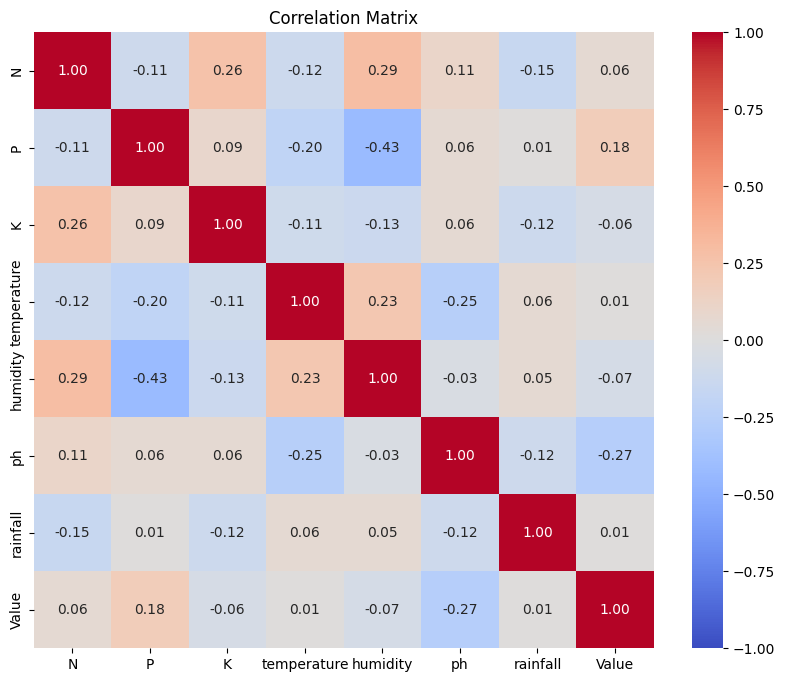

In [20]:
try:
    print("--- Exploratory Data Analysis (EDA) ---")
    print("Generating Correlation Heatmap...")
    
    plt.figure(figsize=(10, 8))
    
    # Correlation only on numeric columns
    corr_matrix = final_df[numeric_cols].corr()
    
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
    plt.title('Correlation Matrix')
    plt.show()

except Exception as e:
    print(f"Error: {e}")


Generating Average Yield Bar Chart...


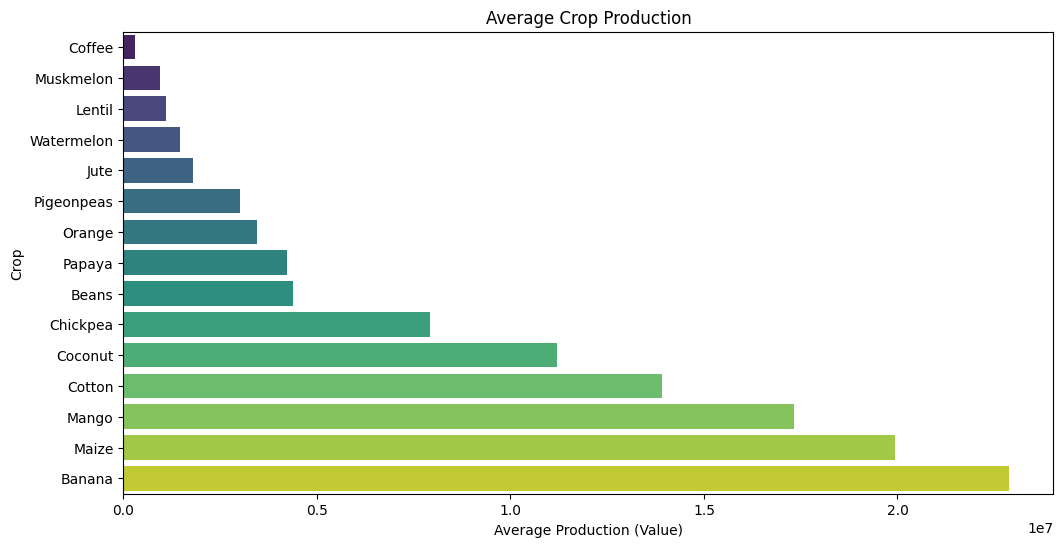

In [21]:
try:
    print("Generating Average Yield Bar Chart...")
    
    avg_vals = final_df.groupby('label')['Value'].mean().sort_values()
    
    plt.figure(figsize=(12, max(6, len(avg_vals) * 0.4)))
    sns.barplot(y=avg_vals.index, x=avg_vals.values, palette='viridis')
    plt.xlabel('Average Production (Value)')
    plt.ylabel('Crop')
    plt.title('Average Crop Production')
    plt.show()

except Exception as e:
    print(f"Error: {e}")


In [22]:
# ==========================================
# 🧠 SMART DATA ENGINEERING (With Kilotonnes)
# ==========================================
# Run this BEFORE creating X and y!

import numpy as np

print("🔄 Applying Smart Yield Engineering...")

# 1. Calculate 'Ideal' (Mean) conditions
crop_means = final_df.groupby('label')[['N', 'P', 'K', 'temperature', 'rainfall', 'humidity', 'ph']].mean()

def engineer_smart_yield(row):
    crop = row['label']
    ideal = crop_means.loc[crop]
    
    # 2. Deviation Calculation
    n_dev = abs(row['N'] - ideal['N']) / (ideal['N'] + 1)
    p_dev = abs(row['P'] - ideal['P']) / (ideal['P'] + 1)
    k_dev = abs(row['K'] - ideal['K']) / (ideal['K'] + 1)
    rain_dev = abs(row['rainfall'] - ideal['rainfall']) / (ideal['rainfall'] + 1)
    temp_dev = abs(row['temperature'] - ideal['temperature']) / (ideal['temperature'] + 1)
    
    # 3. Apply Penalty
    penalty = (n_dev * 0.15) + (p_dev * 0.15) + (k_dev * 0.15) + (rain_dev * 0.35) + (temp_dev * 0.20)
    penalty = min(penalty, 0.75) 
    
    # 4. Randomness
    random_factor = np.random.uniform(0.90, 1.10)
    
    # 5. CONVERT TO KILOTONNES HERE (Divide by 1000)
    # Original Value was in Tonnes/Kg, now it becomes Kilotonnes
    new_yield = (row['Value'] / 1000) * (1 - penalty) * random_factor
    return new_yield

# Apply Logic
final_df['Value'] = final_df.apply(engineer_smart_yield, axis=1)

print("✅ Data Fixed! Values are now in KILOTONNES & Dynamic.")
print(final_df[final_df['label'] == 'Banana'][['N', 'Value']].head())

🔄 Applying Smart Yield Engineering...
✅ Data Fixed! Values are now in KILOTONNES & Dynamic.
        N         Value
7400   91  11999.496714
7401  105  13054.752621
7402  108  13240.987619
7403   86  12064.480999
7404   80  11835.672471


In [23]:
# ==========================================
# 🛠️ FIX: SCALING & LOG TRANSFORM (CELL 22)
# ==========================================
from sklearn.preprocessing import StandardScaler
import numpy as np
import joblib

try:
    print("🔄 Preparing Data with Log-Transform & Scaling...")
    
    # 1. Define Features (X) and Target (y)
    # DROP 'Value' (Target) and 'Element' (Extra Text)
    X = final_df.drop(columns=['Value', 'Element'], errors='ignore')
    
    # --- MAJOR CHANGE 1: LOG TRANSFORM TARGET ---
    # Production values bohot badi hain (Lakhs mein), unhe chota kar rahe hain.
    # Ex: 10,00,000 ban jayega approx 13.8.
    y = np.log1p(final_df['Value']) 
    print("✅ Target (Yield) Log-Transformed successfully.")

    # 2. NUMERIC SCALING
    # N, P, K, Temp wagera alag scales par hain. Unhe ek scale (0-1) par laana zaroori hai.
    numeric_cols = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
    
    # Scaler create aur fit karo
    scaler = StandardScaler()
    X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
    
    # Save Scaler (Backend mein zaroorat padegi input scale karne ke liye)
    joblib.dump(scaler, 'Datasets/scaler.joblib')
    print("✅ Numeric Features Scaled & Scaler Saved.")

    # 3. Capture Input Ranges (For Website Sliders)
    # Original (Unscaled) ranges chahiye user ko dikhane ke liye
    input_ranges = {col: (final_df[col].min(), final_df[col].max()) for col in numeric_cols}
    joblib.dump(input_ranges, 'Datasets/input_ranges.joblib')

    # 4. One-Hot Encoding
    # drop_first=False rakha hai taaki pehla crop (Banana) gayab na ho
    X = pd.get_dummies(X, columns=['label'], drop_first=False)
    
    # Save Model Columns List
    model_columns = list(X.columns)
    joblib.dump(model_columns, 'Datasets/model_columns.joblib')
    
    print(f"✅ Data Ready. Features: {X.shape[1]}")
    print("\nSample Scaled X (First 3 rows):")
    print(X[numeric_cols].head(3))

except Exception as e:
    print(f"Error: {e}")
# try:
#     print("Preparing Training Data & Input Ranges...")
    
#     # 1. Define Target and Features
#     # We drop 'Value' (Target) and 'Element' (Category Label)
#     X = final_df.drop(columns=['Value', 'Element'], errors='ignore')
#     y = final_df['Value']

#     # 2. Capture Numeric Ranges for User Input Suggestions
#     # This helps the user know what values are valid during the live demo
#     numeric_cols = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
#     input_ranges = {col: (final_df[col].min(), final_df[col].max()) for col in numeric_cols}
    
#     # 3. One-Hot Encoding for Crop Names ('label')
#     # Converting text categories into numbers the model can understand
#     X = pd.get_dummies(X, columns=['label'], drop_first=False)
    
#     # 4. Save metadata for the prediction tool
#     import joblib
#     joblib.dump(input_ranges, 'Datasets/input_ranges.joblib')
    
#     print(f"✅ Success: Features Generated: {X.shape[1]}")
#     print(f"✅ Input ranges captured for {len(numeric_cols)} columns.")
#     print("\nFeature List:")
#     print(X.columns.tolist())

# except Exception as e:
#     print(f"Error: {e}")


🔄 Preparing Data with Log-Transform & Scaling...
✅ Target (Yield) Log-Transformed successfully.
✅ Numeric Features Scaled & Scaler Saved.
✅ Data Ready. Features: 22

Sample Scaled X (First 3 rows):
             N         P         K  temperature  humidity        ph  rainfall
7400  0.757722  2.278693  0.692214     0.845620  0.249972 -0.508738 -0.182215
7401  1.113538  2.322930  0.925879     0.326147  0.607681 -0.949658 -0.028793
7402  1.189785  2.190220  1.101127     0.343218  0.573270 -0.322811  0.043771


In [24]:
try:
    # 1. Prepare Features and Target
    X = final_df.drop(columns=['Value', 'Element'], errors='ignore')
    y = final_df['Value']
    
    # 2. One-Hot Encoding
    X = pd.get_dummies(X, columns=['label'], drop_first=False)
    
    # 3. Split Data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # 4. Calculate ranges for user input suggestions later
    numeric_cols = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
    ranges = {col: (final_df[col].min(), final_df[col].max()) for col in numeric_cols}
    
    print(f"✅ Data Ready. Features: {X.shape[1]} | Train Rows: {X_train.shape[0]}")
except Exception as e:
    print(f"Error: {e}")

✅ Data Ready. Features: 22 | Train Rows: 24704


In [25]:
try:
    # Initialize baseline models
    models = {
        "Linear Regression": LinearRegression(),
        "Random Forest": RandomForestRegressor(random_state=42),
        "XGBoost": XGBRegressor(random_state=42)
    }

    for name, model in models.items():
        model.fit(X_train, y_train)
        
        # Calculate scores for Research (Train vs Test)
        train_r2 = model.score(X_train, y_train)
        test_r2 = model.score(X_test, y_test)
        
        # Calculate Error (RMSE)
        test_rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
        
        print(f"\nModel: {name}")
        print(f"   Train Accuracy (R²): {train_r2:.4f}")
        print(f"   Test Accuracy (R²) : {test_r2:.4f}")
        print(f"   Test Error (RMSE)  : {test_rmse:.2f}")
except Exception as e:
    print(f"Error: {e}")


Model: Linear Regression
   Train Accuracy (R²): 0.8478
   Test Accuracy (R²) : 0.8479
   Test Error (RMSE)  : 2717.80

Model: Random Forest
   Train Accuracy (R²): 0.8530
   Test Accuracy (R²) : 0.8352
   Test Error (RMSE)  : 2828.79

Model: XGBoost
   Train Accuracy (R²): 0.8530
   Test Accuracy (R²) : 0.8359
   Test Error (RMSE)  : 2822.95


In [26]:
from sklearn.model_selection import GridSearchCV

try:
    param_grids = {
        'Random Forest': {'n_estimators': [50, 100], 'max_depth': [10, None]},
        'XGBoost': {'n_estimators': [50, 100], 'learning_rate': [0.05, 0.1]}
    }

    best_models = {"Linear Regression": models["Linear Regression"]}
    final_results = []

    # Include Linear Regression (Baseline) in results first
    lr_test_r2 = models["Linear Regression"].score(X_test, y_test)
    lr_rmse = np.sqrt(mean_squared_error(y_test, models["Linear Regression"].predict(X_test)))
    final_results.append({"Model": "Linear Regression", "Test R²": lr_test_r2, "RMSE": lr_rmse, "Status": "Baseline"})

    for name in ['Random Forest', 'XGBoost']:
        print(f"Tuning {name}...")
        grid = GridSearchCV(models[name], param_grids[name], cv=3, n_jobs=-1)
        grid.fit(X_train, y_train)
        
        m = grid.best_estimator_
        best_models[name] = m
        
        r2 = m.score(X_test, y_test)
        rmse = np.sqrt(mean_squared_error(y_test, m.predict(X_test)))
        final_results.append({"Model": name, "Test R²": r2, "RMSE": rmse, "Status": "Tuned"})

    # Display Comparison Table
    comparison_df = pd.DataFrame(final_results).sort_values(by="Test R²", ascending=False)
    print("\n--- Final Model Selection Table ---")
    print(comparison_df.to_string(index=False))

    # Select winner
    best_name = comparison_df.iloc[0]['Model']
    best_model = best_models[best_name]
    print(f"\n🏆 Selected Model: {best_name}")

except Exception as e:
    print(f"Error: {e}")

Tuning Random Forest...
Tuning XGBoost...

--- Final Model Selection Table ---
            Model  Test R²        RMSE   Status
Linear Regression 0.847903 2717.799916 Baseline
          XGBoost 0.842147 2768.743231    Tuned
    Random Forest 0.837924 2805.534714    Tuned

🏆 Selected Model: Linear Regression


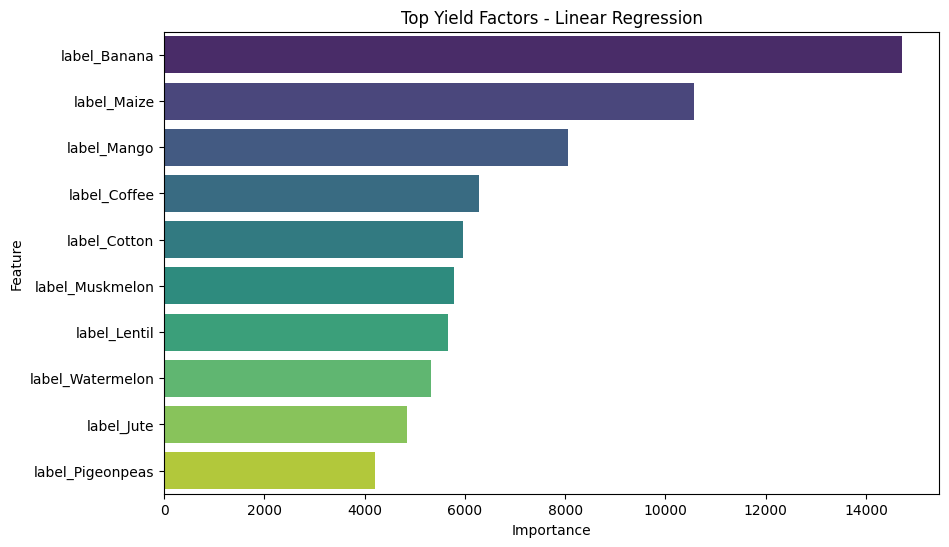

✅ Model and Metadata Saved.


In [27]:
try:
    importances = None
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
    elif hasattr(best_model, 'coef_'):
        importances = abs(best_model.coef_)

    if importances is not None:
        imp_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values('Importance', ascending=False).head(10)
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=imp_df, palette='viridis')
        plt.title(f'Top Yield Factors - {best_name}')
        plt.show()

    joblib.dump(best_model, 'Datasets/agri_yield_model.joblib')
    joblib.dump(X.columns.tolist(), 'Datasets/model_columns.joblib')
    joblib.dump(ranges, 'Datasets/input_ranges.joblib') # Saving ranges for the tool
    print("✅ Model and Metadata Saved.")
except Exception as e:
    print(f"Error: {e}")

In [28]:
# ==========================================
# 🛠️ FIXED CODE: NO ANTI-LOG NEEDED
# ==========================================
def check_model_on_input(n, p, k, temp, hum, ph, rain, crop):
    try:
        # Load Model & Scaler
        model = joblib.load('Datasets/agri_yield_model.joblib')
        model_cols = joblib.load('Datasets/model_columns.joblib')
        scaler = joblib.load('Datasets/scaler.joblib') 
       
        # 1. Prepare Input Row
        input_data = {
            'N': n, 'P': p, 'K': k, 
            'temperature': temp, 'humidity': hum, 
            'ph': ph, 'rainfall': rain
        }
       
        # Convert to DataFrame
        row = pd.DataFrame([input_data])
       
        # Add Missing Columns (Crop One-Hot Encoding)
        for col in model_cols:
            if col not in row.columns:
                row[col] = 0
       
        # Set Crop Column to 1
        crop_col = f"label_{crop}"
        if crop_col in row.columns:
            row[crop_col] = 1
           
        # Reorder columns to match training
        row = row[model_cols]
       
        # Scale Input (Keep this if you scaled training data)
        numeric_cols = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall']
        row[numeric_cols] = scaler.transform(row[numeric_cols])
       
        # --- FIXED PREDICTION ---
        # The model output is ALREADY the yield. We do not use np.exp or log logic.
        predicted_yield = model.predict(row)[0]
       
        print(f"✅ Input: {crop} | N:{n} P:{p} K:{k}")
        print(f"💰 Predicted Yield: {predicted_yield:.2f} (Kilotonnes)")
       
        return predicted_yield

    except Exception as e:
        print(f"Error: {e}")
        return None

# Test with dummy data
check_model_on_input(90, 42, 43, 20.8, 82.0, 6.5, 202.9, 'Jute')

✅ Input: Jute | N:90 P:42 K:43
💰 Predicted Yield: 2569.43 (Kilotonnes)


np.float64(2569.4300276230297)

In [ ]:

def predict_with_validation():
    try:
        # Load necessary metadata
        ranges = joblib.load('Datasets/input_ranges.joblib')
        model = joblib.load('Datasets/agri_yield_model.joblib')
        cols = joblib.load('Datasets/model_columns.joblib')
        
        # 1. Get the list of available crops from the model columns
        # Filter columns that start with 'label_' and clean them for display
        available_crops = [c.replace('label_', '') for c in cols if c.startswith('label_')]
        
        print("\n" + "---"* 20 ," 🌾 AI AgriYield Predictor ",  20 * "---" + "\n" )
        print(f"Available Crops: {', '.join(available_crops)}")
        print("\n" + "-" * 149)

        # 2. Validated Crop Selection
        user_crop = input("\nEnter Crop Name from the list above: ").strip()
        
        # Validation: Check if crop exists (Case-Insensitive)
        matched_crop = next((c for c in available_crops if c.lower() == user_crop.lower()), None)
        
        if not matched_crop:
            print(f"❌ Error: '{user_crop}' is not a valid crop in our system. Please check spelling.")
            return

        # 3. Numeric Inputs with Range Validation
        print(f"\nEntering data for {matched_crop}:")
        
        def get_valid_input(label, min_val, max_val, unit=""):
            while True:
                try:
                    val = float(input(f"   {label} [{min_val:.1f} - {max_val:.1f}{unit}]: "))
                    if min_val <= val <= max_val:
                        return val
                    else:
                        print(f"      ⚠️ Out of range! Please enter a value between {min_val} and {max_val}.")
                except ValueError:
                    print("      ⚠️ Invalid input! Please enter a numeric value.")

        n = get_valid_input("Nitrogen (N)", *ranges['N'])
        p = get_valid_input("Phosphorus (P)", *ranges['P'])
        k = get_valid_input("Potassium (K)", *ranges['K'])
        temp = get_valid_input("Temperature", *ranges['temperature'], "°C")
        hum = get_valid_input("Humidity", *ranges['humidity'], "%")
        ph = get_valid_input("pH", *ranges['ph'])
        rain = get_valid_input("Rainfall", *ranges['rainfall'], "mm")

        # 4. Create Prediction Row
        row = pd.DataFrame(np.zeros((1, len(cols))), columns=cols)
        row['N'], row['P'], row['K'], row['ph'] = n, p, k, ph
        row['temperature'], row['humidity'], row['rainfall'] = temp, hum, rain
        
        # Set the One-Hot column
        crop_col = f'label_{matched_crop}'
        if crop_col in cols:
            row[crop_col] = 1
            prediction = model.predict(row)[0]
            
            print("\n" + "_"*149  + "\n")
            print(f"✅ SUCCESS: Predicted Yield for {matched_crop}")
            print(f"💰 Estimated Production: {prediction:.2f} units")
            print("\n" + "_"*149)

    except Exception as e:
        print(f"\n⚠️ System Error: {e}")

# Run the validated tool
predict_with_validation()



------------------------------------------------------------  🌾 AI AgriYield Predictor  ------------------------------------------------------------

Available Crops: Banana, Beans, Chickpea, Coconut, Coffee, Cotton, Jute, Lentil, Maize, Mango, Muskmelon, Orange, Papaya, Pigeonpeas, Watermelon

-----------------------------------------------------------------------------------------------------------------------------------------------------



Enter Crop Name from the list above:  Banana



Entering data for Banana:
